In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/")#, one_hot=True)

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz


In [17]:
n_input = 784
n_hidden_1 = 256
n_hidden_2 = 2

x = tf.placeholder(tf.float32,[None,n_input])
print(x.shape)
zinput = tf.placeholder(tf.float32,[None,n_hidden_2])
print(zinput.shape)

(?, 784)
(?, 2)


In [18]:
weights = {

    'w1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],
                                   stddev=0.001)),
    'b1': tf.Variable(tf.zeros([n_hidden_1])),

    'mean_w1': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],
                                   stddev=0.001)),
    'log_sigma_w1': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],
                                   stddev=0.001)),    
    
    
    'w2': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1],
                                   stddev=0.001)),

    'b2': tf.Variable(tf.zeros([n_hidden_1])),
    'w3': tf.Variable(tf.truncated_normal([n_hidden_1, n_input],
                                   stddev=0.001)),

    'b3': tf.Variable(tf.zeros([n_input])),

    'mean_b1': tf.Variable(tf.zeros([n_hidden_2])),

    'log_sigma_b1': tf.Variable(tf.zeros([n_hidden_2]))
}

In [19]:
h1=tf.nn.relu(tf.add(tf.matmul(x, weights['w1']), weights['b1']))
z_mean = tf.add(tf.matmul(h1, weights['mean_w1']), weights['mean_b1'])
z_log_sigma_sq = tf.add(tf.matmul(h1, weights['log_sigma_w1']), weights['log_sigma_b1'])

In [20]:
 # sample from gaussian distribution
eps = tf.random_normal(tf.stack([tf.shape(h1)[0], n_hidden_2]), 0, 1, dtype = tf.float32)
z =tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
h2=tf.nn.relu( tf.matmul(z, weights['w2'])+ weights['b2'])
reconstruction = tf.matmul(h2, weights['w3'])+ weights['b3']


h2out=tf.nn.relu( tf.matmul(zinput, weights['w2'])+ weights['b2'])
reconstructionout = tf.matmul(h2out, weights['w3'])+ weights['b3']

# cost
reconstr_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(reconstruction, x), 2.0))
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq
                                   - tf.square(z_mean)
                                   - tf.exp(z_log_sigma_sq), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)

In [21]:
training_epochs = 50
batch_size = 128
display_step = 3

Epoch: 0001 cost= 2834.129150391
Epoch: 0004 cost= 2436.214843750
Epoch: 0007 cost= 2288.136474609
Epoch: 0010 cost= 2304.993164062
Epoch: 0013 cost= 2097.520996094
Epoch: 0016 cost= 2079.216796875
Epoch: 0019 cost= 2085.196777344
Epoch: 0022 cost= 1873.418823242
Epoch: 0025 cost= 2062.451660156
Epoch: 0028 cost= 2005.114257812
Epoch: 0031 cost= 1861.682617188
Epoch: 0034 cost= 1956.916503906
Epoch: 0037 cost= 1993.515258789
Epoch: 0040 cost= 1888.661743164
Epoch: 0043 cost= 2091.156738281
Epoch: 0046 cost= 1977.961425781
Epoch: 0049 cost= 1915.213867188
完成!
Result: 157812.5


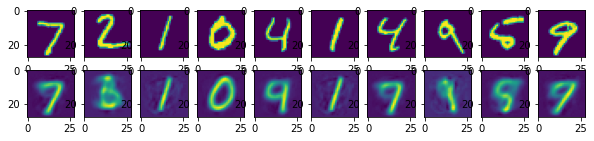

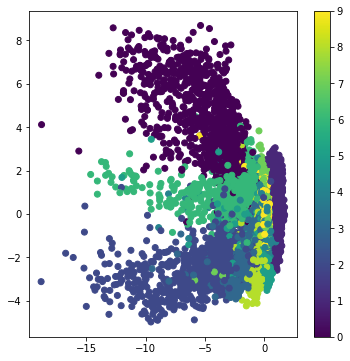

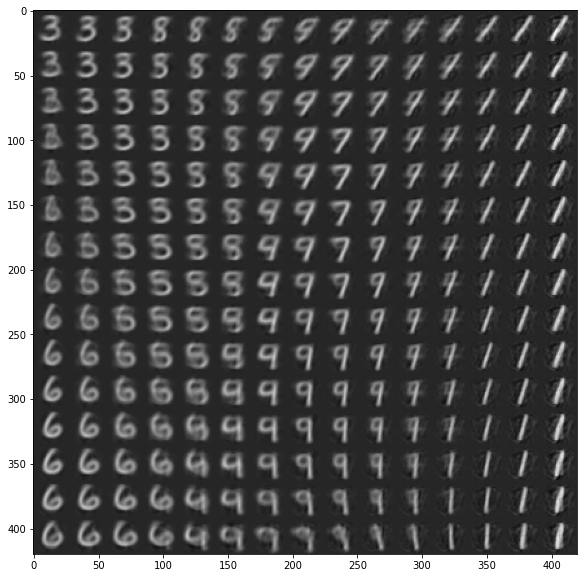

In [22]:
training_epochs = 50
batch_size = 128
display_step = 3



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # 遍历全部数据集
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)#取数据
            
    
            # Fit training using batch data
            _,c = sess.run([optimizer,cost], feed_dict={x: batch_xs})
            #c = autoencoder.partial_fit(batch_xs)
        # 显示训练中的详细信息
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(c))

    print("完成!")
    
    # 测试
    print ("Result:", cost.eval({x: mnist.test.images}))
    
    # 可视化结果
    show_num = 10
    pred = sess.run(
        reconstruction, feed_dict={x: mnist.test.images[:show_num]})

    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(show_num):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(pred[i], (28, 28)))
    plt.draw()
    
    pred = sess.run(
        z, feed_dict={x: mnist.test.images})
    #x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(pred[:, 0], pred[:, 1], c=mnist.test.labels)
    plt.colorbar()
    plt.show()

    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = sess.run(reconstructionout,feed_dict={zinput:z_sample})
            
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()  